In [1]:
!wget https://trademark-sample-dataset.s3.ap-south-1.amazonaws.com/assignment.zip

--2024-06-19 13:40:03--  https://trademark-sample-dataset.s3.ap-south-1.amazonaws.com/assignment.zip
Resolving trademark-sample-dataset.s3.ap-south-1.amazonaws.com (trademark-sample-dataset.s3.ap-south-1.amazonaws.com)... 52.219.160.78, 16.12.36.38, 3.5.212.165, ...
Connecting to trademark-sample-dataset.s3.ap-south-1.amazonaws.com (trademark-sample-dataset.s3.ap-south-1.amazonaws.com)|52.219.160.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 369386524 (352M) [application/zip]
Saving to: ‘assignment.zip’

assignment.zip      100%[===================>] 352.27M  13.8MB/s    in 39s     

2024-06-19 13:40:43 (8.99 MB/s) - ‘assignment.zip’ saved [369386524/369386524]



In [2]:
!unzip assignment.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/98166820.jpg     
  inflating: images/79387655.jpg     
  inflating: images/85889381.jpg     
  inflating: images/75085019.jpg     
  inflating: images/88096598.jpg     
  inflating: images/78876607.jpg     
  inflating: images/78545112.jpg     
  inflating: images/88131477.jpg     
  inflating: images/77134096.jpg     
  inflating: images/87617748.jpg     
  inflating: images/86680332.jpg     
  inflating: images/79364151.jpg     
  inflating: images/88622678.jpg     
  inflating: images/87259419.jpg     
  inflating: images/87879110.jpg     
  inflating: images/77586771.jpg     
  inflating: images/98154418.jpg     
  inflating: images/97930296.jpg     
  inflating: images/87751627.jpg     
  inflating: images/85791852.jpg     
  inflating: images/73653586.jpg     
  inflating: images/85413821.jpg     
  inflating: images/85356491.jpg     
  inflating: images/79088603.jpg     
  inflating: images/73201307.jpg     

In [87]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from collections import Counter
import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [89]:
df = pd.read_csv('/content/animal_class_updated.csv')
images_presented = [image_path.split('/')[1][:-4] for image_path in  glob.glob('images/*')]
df['serial_number'] = df['serial_number'].astype(str)
df = df[df.serial_number.isin(images_presented)]

In [90]:
unique_design_code = Counter([design_code for design_codes in df['design_code'].values for design_code in eval(design_codes)])

In [91]:
classes = list(unique_design_code.keys())

In [92]:
def encode_label(label, classes_list = classes):
    target = torch.zeros(len(classes))
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target


def decode_target(target, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])
    return ' '.join(result)


In [93]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df[['serial_number', 'design_code']].values


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name, label = self.df[idx]
        label = eval(label)

        img = Image.open(f"images/{image_name}.jpg")

        if self.transform:
            img = self.transform(img)

        return img, encode_label(label)

In [94]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images
transform= T.Compose([T.Resize(128),
                      T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [95]:
dataset = myDataset(df, transform = transform)
len(dataset)

10102

Label: 030108 260121 260317 021101 290603 290611 290608 290606

tensor([1., 0., 0.,  ..., 0., 1., 0.])


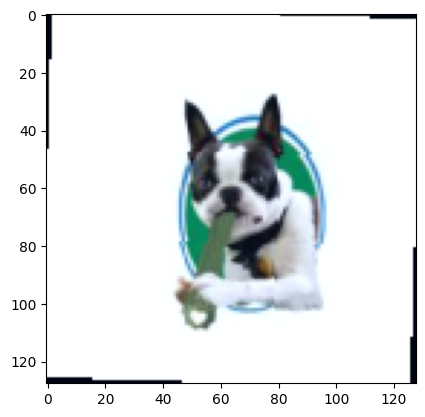

In [96]:
def denorm(img_tensors): #this function will denormalize the tensors
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*dataset[10080]) #let's take an example

In [97]:
val_percent = int(0.15 * len(dataset)) #setting 15 percent of the total number of images for validation
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size

(8587, 1515)

In [98]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #splitting the dataset for training and validation.
len(train_ds), len(val_ds)

(8587, 1515)

In [99]:
#setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

In [100]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32, 1142])


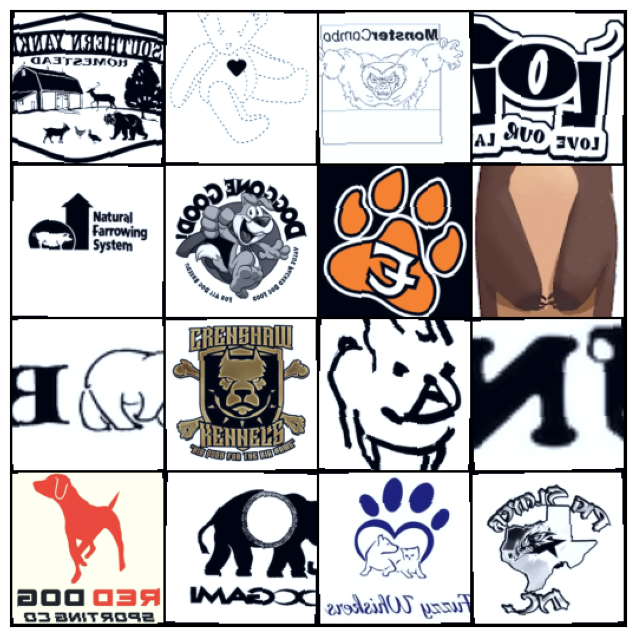

In [101]:
#let's see a batch of images (16 images) in a grid
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)


In [102]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [103]:
#helper functions to load the data and model onto GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [104]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [105]:

# checking up the shapes of the datas
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break


torch.Size([32, 3, 128, 128])
torch.Size([32, 1142])


In [106]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [107]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2


        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 11

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [109]:
model = to_device(ResNet15(3, len(classes)), device) #input size: 3, output size: 11, loading model onto GPU

In [110]:

#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([32, 3, 128, 128])
outputs.shape :  torch.Size([32, 1142])
Sample outputs :
 tensor([[0.7023, 0.6134, 0.7106,  ..., 0.8820, 0.8249, 0.6950],
        [0.5667, 0.5944, 0.8261,  ..., 0.7281, 0.7724, 0.6466]])


In [ ]:
history = [evaluate(model, val_dl)]
history

In [ ]:
epochs = 3
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_ds[200][0]) #checking out the predictions of some images from the validation dataset.